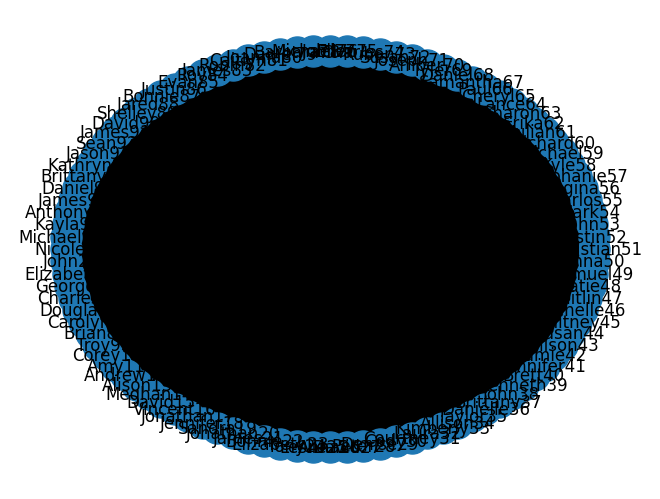

Compatibility Scores: 
John2 --> Elizabeth3: 0.9805250490037049
John2 --> Michael100: 0.9239259585061146
John2 --> Kayla99: 0.9229378669938341
John2 --> Anthony98: 0.9219766111827751
John2 --> George4: 0.9214086870662305
John2 --> James97: 0.9209999123999113
John2 --> Daniel96: 0.919990798017036
John2 --> Brittany95: 0.9189497646395756
John2 --> Kathryn94: 0.9179264523429645
John2 --> Jason93: 0.9169302720724777
John2 --> Sean92: 0.9159320762973007
John2 --> James91: 0.9149397936656546
John2 --> Joanna80: 0.9126376396384044
John2 --> Jared88: 0.911939790462829
John2 --> David90: 0.9115482623396908
John2 --> Bonnie87: 0.9109791350753524
John2 --> Shelley89: 0.9104823088637557
John2 --> Justin86: 0.9099504638771686
John2 --> Evan85: 0.9089428255261959
John2 --> Roy84: 0.9079662841287147
John2 --> James83: 0.9068836117816756
John2 --> Robin82: 0.9058969109661319
John2 --> Caitlyn81: 0.9049707333228338
John2 --> Daniel79: 0.9027968382284579
John2 --> Barbara78: 0.9017619296650606
John2 -->

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np

from pyvis import network as net

df = pd.read_csv("/random_data.csv")
# df = pd.read_csv("profile_dataNewest.csv")

def gcn_main():
    G = nx.Graph()
    label = {}
    likes = {}
    search = {}

    for i, (user, category) in enumerate(zip(df['first_name'], df['categories'])):
        label[i] = user  # Use index as node label
        search[user] = i
        G.add_node(i, title=user, label=user)
        likes[user] = category

    for u in range(len(label)):
        for v in range(len(label)):
            if u != v:
                categories1 = set(likes[label[u]].split(','))
                categories2 = set(likes[label[v]].split(','))
                common_categories = categories1.intersection(categories2)
                union_categories = categories1.union(categories2)
                similarity_score = float(len(common_categories) / len(union_categories)) * 100
                if common_categories:
                    G.add_edge(u, v, weight=similarity_score)

    if G.number_of_edges() == 0:
        print("Error: The graph has no edges.")
        return

    edges = list(G.edges())

    x = torch.randn(len(label), 16)  # Random node features
    edge_index = torch.tensor(edges).t().contiguous()  # Edge indices
    data = Data(x=x, edge_index=edge_index)

    gcn_model = GCNModel(input_dim=16, hidden_dim=32, output_dim=1)  # Output dimension changed to 1 for regression

    gcn_output = gcn_model(data)

    visualize_graph(G, label, search, gcn_output)

    # return gcn_output

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x  # Output dimension changed, no log_softmax

def visualize_graph(G, label, search, gcn_output):
    pos = nx.shell_layout(G)
    nx.draw(G, pos, labels=label, with_labels=True, node_size=500)
    plt.draw()
    plt.show()
    
    user_name = input("Enter user name: ")
    user_index = search.get(user_name)
    if user_index is not None:
        get_score(G, label, user_index, gcn_output, label)
    else:
        print("User not found.")

    nt = net.Network(notebook=True, cdn_resources='remote', height="900px", width="100%", bgcolor="#222222", font_color="white")
    nt.barnes_hut()
    nt.from_nx(G, default_node_size=100, show_edge_weights=True, edge_scaling=True)
    neighbor_map = nt.get_adj_list()
    
    for node in nt.nodes:
        node["title"] += " Neighbors: <br>" + " <br> ".join(str(neighbor_map[node["id"]]))
        node["value"] = len(neighbor_map[node["id"]])

    nt.prep_notebook()
    nt.show('nx.html')

def get_score(G, label, user_index, gcn_output, search):
    user_score = {}
    user_embedding = gcn_output[user_index].detach().numpy()
    for other_user_index in range(len(label)):
        if user_index != other_user_index:
            other_user_embedding = gcn_output[other_user_index].detach().numpy()
            similarity_score = float(
                1.0 / (1.0 + np.linalg.norm(user_embedding - other_user_embedding))  # Cosine similarity
            )
            user_score[other_user_index] = similarity_score

    print("Compatibility Scores: ")
    for user, score in sorted(user_score.items(), key=lambda x: x[1], reverse=True):
        print(f"{label[user_index]} --> {label[user]}: {score}")

gcn_main()
